<a href="https://colab.research.google.com/github/AudriBanik/finalproject/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install numpy pandas torch matplotlib scipy tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import os
import time

# Download datasets
if not os.path.exists("PEMS-BAY.csv"):
    print("Downloading PEMS-BAY dataset...")
    !wget -O PEMS-BAY.csv "https://zenodo.org/records/5146275/files/PEMS-BAY.csv?download=1"

if not os.path.exists("METR-LA.csv"):
    print("Downloading METR-LA dataset...")
    !wget -O METR-LA.csv "https://zenodo.org/records/5146275/files/METR-LA.csv?download=1"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function to dynamically determine the number of nodes
def get_num_nodes(csv_file):
    data = pd.read_csv(csv_file).select_dtypes(include=[np.number])
    return data.shape[1]

# Data Preprocessing
def preprocess_csv(filepath, seq_length=12, pred_length=12, sample_frac=1.0):
    traffic_data = pd.read_csv(filepath)
    traffic_data = traffic_data.select_dtypes(include=[np.number]).values

    if sample_frac < 1.0:
        num_samples = int(len(traffic_data) * sample_frac)
        traffic_data = traffic_data[:num_samples]

    mean = traffic_data.mean()
    std = traffic_data.std()
    traffic_data = (traffic_data - mean) / std

    num_samples = traffic_data.shape[0]
    num_train = int(num_samples * 0.6)
    num_val = int(num_samples * 0.2)
    train_data = traffic_data[:num_train]
    val_data = traffic_data[num_train:num_train + num_val]
    test_data = traffic_data[num_train + num_val:]

    def create_sequences(data):
        X, Y = [], []
        for i in range(len(data) - seq_length - pred_length):
            X.append(data[i:i + seq_length])
            Y.append(data[i + seq_length:i + seq_length + pred_length])
        return np.array(X), np.array(Y)

    X_train, Y_train = create_sequences(train_data)
    X_val, Y_val = create_sequences(val_data)
    X_test, Y_test = create_sequences(test_data)

    return (
        TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                      torch.tensor(Y_train, dtype=torch.float32).to(device)),
        TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device),
                      torch.tensor(Y_val, dtype=torch.float32).to(device)),
        TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device),
                      torch.tensor(Y_test, dtype=torch.float32).to(device)),
    )

# Models
class GRUModel(nn.Module):
    def __init__(self, num_nodes, hidden_size, layers=1):
        super().__init__()
        self.gru = nn.GRU(num_nodes, hidden_size, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_nodes)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

class GRUWithGN(nn.Module):
    def __init__(self, adjacency_matrix, num_nodes, hidden_size=64):
        super().__init__()
        self.adjacency = nn.Parameter(torch.tensor(adjacency_matrix, dtype=torch.float32), requires_grad=False)
        self.gru = nn.GRU(num_nodes, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_nodes)  # Project GRU output to node-specific features
        self.fc2 = nn.Linear(num_nodes, 256)  # MLP layer
        self.fc3 = nn.Linear(256, num_nodes)  # Output layer

    def forward(self, x):
        # Get GRU hidden states
        _, h_n = self.gru(x)  # h_n: (num_layers, batch_size, hidden_size)
        h_n = h_n[-1]  # Use the last layer's hidden state: (batch_size, hidden_size)

        # Project to node space
        node_features = self.fc1(h_n)  # (batch_size, num_nodes)

        # Apply adjacency matrix
        node_features = torch.einsum('ij,bj->bi', self.adjacency, node_features)  # (batch_size, num_nodes)

        # Pass through MLP
        h = torch.relu(self.fc2(node_features))  # (batch_size, 256)
        return self.fc3(h)  # (batch_size, num_nodes)


class GRUFedAvg(GRUModel):
    pass

class GRUWithFMTL(nn.Module):
    def __init__(self, num_nodes, hidden_size, adjacency_matrix, lambda_reg=0.1):
        super().__init__()
        self.gru = nn.GRU(num_nodes, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_nodes)
        self.adjacency = nn.Parameter(torch.tensor(adjacency_matrix, dtype=torch.float32), requires_grad=False)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        _, h = self.gru(x)  # h: (1, batch_size, hidden_size)
        output = self.fc(h.squeeze(0))  # output: (batch_size, num_nodes)
        return output

    def regularization_loss(self, output):
        # Compute the Laplacian matrix
        laplacian = torch.diag(self.adjacency.sum(dim=1)) - self.adjacency

        # Validate dimensions
        if output.shape[1] != self.adjacency.shape[0]:
            raise ValueError(
                f"Output dimensions {output.shape} do not match adjacency matrix dimensions {self.adjacency.shape}."
            )

        # Compute the trace regularization term
        return self.lambda_reg * torch.trace(output @ laplacian @ output.T)



# CNFGNN Model
class CNFGNN(nn.Module):
    def __init__(self, adjacency_matrix, num_nodes, hidden_size=64):
        """
        A Graph Neural Network model for traffic prediction that uses an adjacency matrix
        for spatial dependency aggregation.
        """
        super().__init__()

        # Ensure the adjacency matrix is a torch.Tensor
        if not isinstance(adjacency_matrix, torch.Tensor):
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

        # Register the adjacency matrix as a parameter without gradients
        self.adjacency = nn.Parameter(adjacency_matrix, requires_grad=False)
        self.num_nodes = num_nodes

        # Define the fully connected layers
        self.fc1 = nn.Linear(num_nodes, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_nodes)

    def forward(self, x):
        """
        Forward pass of the CNFGNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_nodes).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_nodes).
        """
        # Validate input dimensions
        if x.size(-1) != self.num_nodes:
            raise ValueError(
                f"Input last dimension {x.size(-1)} does not match the number of nodes {self.num_nodes}."
            )

        # Apply adjacency matrix to each time step
        # Transpose x to (batch_size, num_nodes, seq_length)
        x = x.transpose(1, 2)  # Now x has shape (batch_size, num_nodes, seq_length)

        # Perform the einsum operation with the correct dimensions
        x = torch.einsum('ij,bjk->bik', self.adjacency, x)
        # Now x has shape (batch_size, num_nodes, seq_length)

        # Transpose x back to original shape (batch_size, seq_length, num_nodes)
        x = x.transpose(1, 2)

        # Aggregate over the temporal dimension (mean pooling across seq_length)
        x = x.mean(dim=1)

        # Pass through MLP (hidden layer and output layer)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


def compute_adjacency_from_csv(csv_file):
    data = pd.read_csv(csv_file).select_dtypes(include=[np.number])
    num_nodes = data.shape[1]
    adjacency = np.ones((num_nodes, num_nodes))  # Example adjacency matrix
    np.fill_diagonal(adjacency, 0)  # Remove self-loops if needed
    return adjacency


# RMSE Evaluation
def evaluate_rmse(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            output = model(X_batch)
            target = Y_batch.mean(dim=1)
            if output.dim() == 3:
                output = output.mean(dim=1)
            y_true.extend(target.cpu().numpy().flatten())
            y_pred.extend(output.cpu().numpy().flatten())
    return np.sqrt(mean_squared_error(y_true, y_pred))

def train_gru_fedavg(num_nodes, train_loader, test_loader, epochs=10, node_fraction=0.5):
    """Federated Averaging for GRU with optimizations."""
    local_models = [GRUModel(num_nodes, hidden_size=100).to(device) for _ in range(num_nodes)]
    global_model = GRUModel(num_nodes, hidden_size=100).to(device)
    epoch_rmse = []
    start_time = time.time()
    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)
                target = Y_batch.mean(dim=1)
                loss = nn.MSELoss()(output, target)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights to all local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())
        rmse = evaluate_rmse(global_model, test_loader)
        epoch_rmse.append(rmse)
        print(f"Epoch {epoch + 1}: Global RMSE = {rmse:.4f}")

    total_time = time.time() - start_time  # End timing
    print(f"Total Training Time for GRU + FedAvg: {total_time:.2f} seconds")
    return epoch_rmse, total_time




def train_gru_fmtl(num_nodes, train_loader, test_loader, adjacency_matrix, lambda_reg=0.1, epochs=10, node_fraction=0.5):
    """Federated Multi-Task Learning with Regularization (optimized)."""
    local_models = [GRUWithFMTL(num_nodes, hidden_size=100, adjacency_matrix=adjacency_matrix, lambda_reg=lambda_reg).to(device) for _ in range(num_nodes)]
    global_model = GRUWithFMTL(num_nodes, hidden_size=100, adjacency_matrix=adjacency_matrix, lambda_reg=lambda_reg).to(device)
    epoch_rmse = []
    start_time = time.time()
    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)  # Predictions
                target = Y_batch.mean(dim=1)  # Target values
                loss = nn.MSELoss()(output, target)

                # Add regularization loss using the output
                loss += lambda_reg * local_models[node].regularization_loss(output)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights back to local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())
        rmse = evaluate_rmse(global_model, test_loader)
        epoch_rmse.append(rmse)
        print(f"Epoch {epoch + 1}: Global RMSE = {rmse:.4f}")

    total_time = time.time() - start_time  # End timing
    print(f"Total Training Time for GRU + FedAvg: {total_time:.2f} seconds")
    return epoch_rmse, total_time


def train_cnfgnn_federated(num_nodes, train_loader, test_loader, adjacency_matrix, epochs=10, node_fraction=0.5):
    """Federated CNFGNN training with optimizations."""
    local_models = [CNFGNN(adjacency_matrix, num_nodes).to(device) for _ in range(num_nodes)]
    global_model = CNFGNN(adjacency_matrix, num_nodes).to(device)
    epoch_rmse = []
    start_time = time.time()
    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)  # Predictions
                target = Y_batch.mean(dim=1)  # Target values aggregated across time
                loss = nn.MSELoss()(output, target)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights back to local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())

        rmse = evaluate_rmse(global_model, test_loader)
        epoch_rmse.append(rmse)
        print(f"Epoch {epoch + 1}: Global RMSE = {rmse:.4f}")

    total_time = time.time() - start_time  # End timing
    print(f"Total Training Time for GRU + FedAvg: {total_time:.2f} seconds")
    return epoch_rmse, total_time


def train_and_evaluate(model, train_loader, test_loader, epochs=10, use_regularization=False, lambda_reg=0.1):
    """
    Train and evaluate a model using given DataLoaders with training time tracking.

    Args:
        model (nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        use_regularization (bool): Whether to apply regularization.
        lambda_reg (float): Regularization coefficient.

    Returns:
        List[float], float: List of RMSE values for each epoch, total training time.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses, rmse_values = [], []

    # Start timing
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        batch_losses = []

        # Training loop
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)  # Predictions
            target = Y_batch.mean(dim=1)  # Target values

            # Handle output dimensions
            if output.dim() == 3:
                output = output.mean(dim=1)

            # Loss computation
            loss = criterion(output, target)

            # Add regularization loss if applicable
            if use_regularization and hasattr(model, 'regularization_loss'):
                reg_loss = model.regularization_loss(model.fc.weight)
                loss += lambda_reg * reg_loss

            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        losses.append(np.mean(batch_losses))
        print(f"Epoch {epoch + 1}: Training Loss = {losses[-1]:.4f}")

        # RMSE Evaluation
        rmse = evaluate_rmse(model, test_loader)
        rmse_values.append(rmse)
        print(f"Epoch {epoch + 1}: Test RMSE = {rmse:.4f}")

    # End timing
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f} seconds")

    return rmse_values, total_time


# Dictionary to store training times
training_times = {}
def plot_training_times(training_times):
    """Function to plot training times for all models and datasets"""
    for dataset, times in training_times.items():
        model_names = list(times.keys())
        training_durations = list(times.values())

        plt.figure(figsize=(12, 7))
        plt.bar(model_names, training_durations, color='skyblue', edgecolor='black')
        plt.title(f"Training Time Comparison for {dataset}")
        plt.xlabel("Models")
        plt.ylabel("Training Time (seconds)")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()


In [ ]:
# Main Experiment Loop
datasets = ["PEMS-BAY", "METR-LA"]
results = {}
training_times = {}
for dataset in datasets:
    csv_file = f"{dataset}.csv"
    num_nodes = get_num_nodes(csv_file)
    adjacency_matrix = compute_adjacency_from_csv(csv_file)

    # Load data
    train_data, val_data, test_data = preprocess_csv(csv_file)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # Initialize dictionary for the dataset
    training_times[dataset] = {}

    # Train GRU (1 Layer)
    print(f"\nTraining GRU (1 Layer) on {dataset}...")
    gru_1_model = GRUModel(num_nodes, hidden_size=100).to(device)
    start_time = time.time()  # Start timing
    gru_1_rmse, _ = train_and_evaluate(gru_1_model, train_loader, test_loader, epochs=10)
    end_time = time.time()  # End timing
    results[f"{dataset}_GRU_1_Layer"] = gru_1_rmse
    training_times[dataset]["GRU (1 Layer)"] = end_time - start_time  # Store training time

    # Train GRU (2 Layers)
    print(f"\nTraining GRU (2 Layers) on {dataset}...")
    gru_2_model = GRUModel(num_nodes, hidden_size=200, layers=2).to(device)
    start_time = time.time()
    gru_2_rmse, _ = train_and_evaluate(gru_2_model, train_loader, test_loader, epochs=10)
    end_time = time.time()
    results[f"{dataset}_GRU_2_Layer"] = gru_2_rmse
    training_times[dataset]["GRU (2 Layers)"] = end_time - start_time

    # GRU + GN (Centralized)
    print(f"\nTraining GRU + GN on {dataset}...")
    gru_gn_model = GRUWithGN(adjacency_matrix, num_nodes, hidden_size=100).to(device)
    start_time = time.time()
    gru_gn_rmse, _ = train_and_evaluate(gru_gn_model, train_loader, test_loader, epochs=10)
    end_time = time.time()
    results[f"{dataset}_GRU_GN"] = gru_gn_rmse
    training_times[dataset]["GRU + GN"] = end_time - start_time

    print(f"\nTraining GRU + FedAvg on {dataset}...")
    fedavg_rmse, fedavg_time = train_gru_fedavg(num_nodes, train_loader, test_loader, epochs=10)
    results[f"{dataset}_GRU_FedAvg"] = fedavg_rmse
    training_times[f"{dataset}_GRU_FedAvg"] = fedavg_time

    print(f"\nTraining GRU + FMTL on {dataset}...")
    fmtl_rmse, fmtl_time = train_gru_fmtl(num_nodes, train_loader, test_loader, adjacency_matrix, epochs=10)
    results[f"{dataset}_GRU_FMTL"] = fmtl_rmse
    training_times[f"{dataset}_GRU_FMTL"] = fmtl_time

    print(f"\nTraining CNFGNN on {dataset}...")
    cnfgnn_rmse, cnfgnn_time = train_cnfgnn_federated(num_nodes, train_loader, test_loader, adjacency_matrix, epochs=10)
    results[f"{dataset}_CNFGNN"] = cnfgnn_rmse
    training_times[f"{dataset}_CNFGNN"] = cnfgnn_time





Training GRU (1 Layer) on PEMS-BAY...
Epoch 1: Training Loss = 0.1572
Epoch 1: Test RMSE = 0.4280
Epoch 2: Training Loss = 0.0940
Epoch 2: Test RMSE = 0.4185
Epoch 3: Training Loss = 0.0813
Epoch 3: Test RMSE = 0.4139
Epoch 4: Training Loss = 0.0746
Epoch 4: Test RMSE = 0.4109
Epoch 5: Training Loss = 0.0702
Epoch 5: Test RMSE = 0.4124
Epoch 6: Training Loss = 0.0672
Epoch 6: Test RMSE = 0.4135
Epoch 7: Training Loss = 0.0652
Epoch 7: Test RMSE = 0.4136
Epoch 8: Training Loss = 0.0634
Epoch 8: Test RMSE = 0.4157
Epoch 9: Training Loss = 0.0618
Epoch 9: Test RMSE = 0.4221
Epoch 10: Training Loss = 0.0605
Epoch 10: Test RMSE = 0.4208
Total Training Time: 32.11 seconds

Training GRU (2 Layers) on PEMS-BAY...
Epoch 1: Training Loss = 0.1332
Epoch 1: Test RMSE = 0.4146
Epoch 2: Training Loss = 0.0795
Epoch 2: Test RMSE = 0.3965
Epoch 3: Training Loss = 0.0633
Epoch 3: Test RMSE = 0.3995
Epoch 4: Training Loss = 0.0537
Epoch 4: Test RMSE = 0.3995
Epoch 5: Training Loss = 0.0473
Epoch 5: Tes

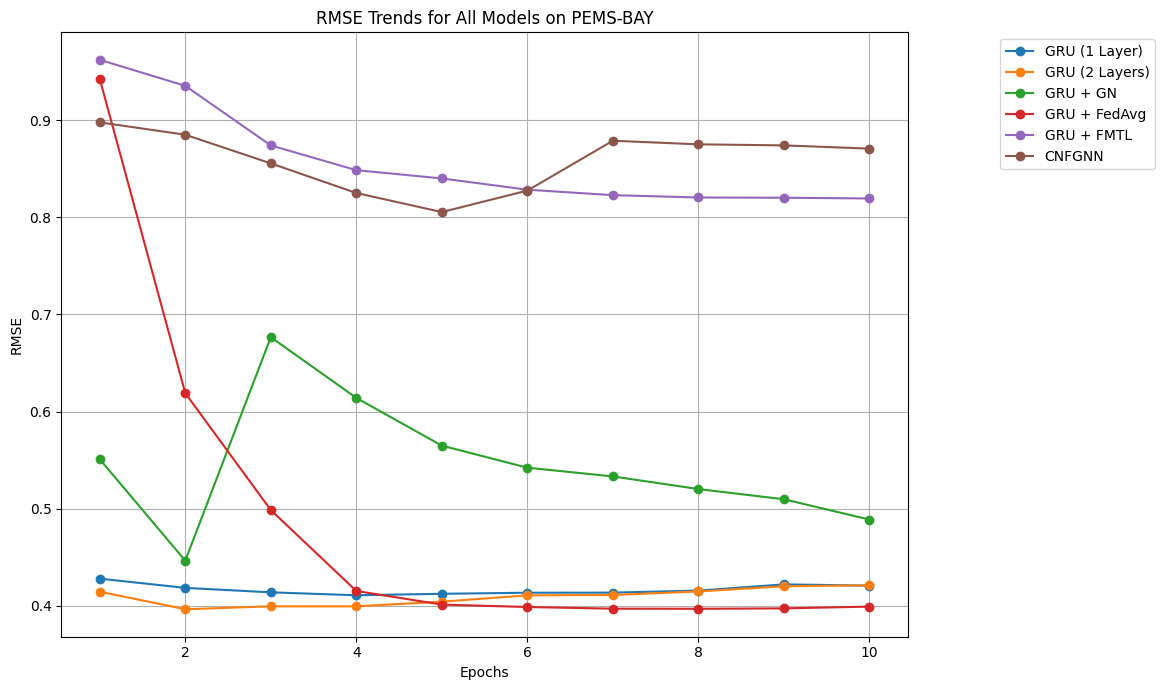

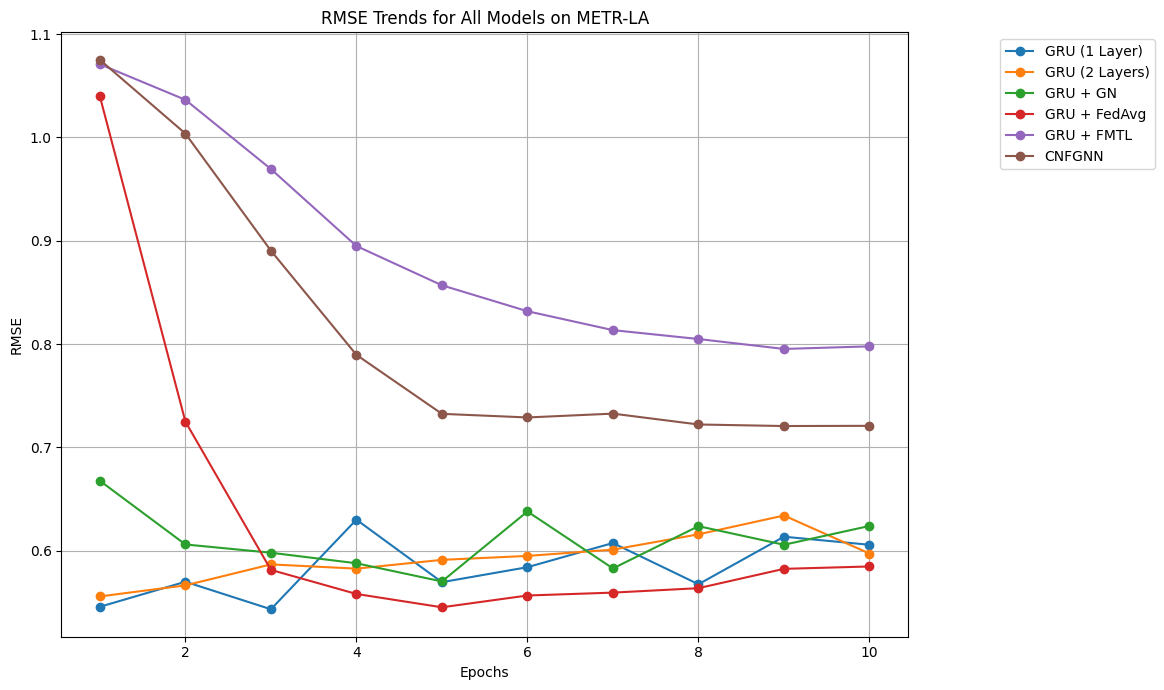


PEMS-BAY RMSE Results:
          GRU (1 Layer)  GRU (2 Layers)  GRU + GN  GRU + FedAvg  GRU + FMTL  \
Epoch 1          0.4280          0.4146    0.5509        0.9423      0.9620   
Epoch 2          0.4185          0.3965    0.4465        0.6189      0.9352   
Epoch 3          0.4139          0.3995    0.6765        0.4986      0.8739   
Epoch 4          0.4109          0.3995    0.6140        0.4153      0.8484   
Epoch 5          0.4124          0.4043    0.5649        0.4013      0.8399   
Epoch 6          0.4135          0.4108    0.5422        0.3988      0.8283   
Epoch 7          0.4136          0.4112    0.5332        0.3971      0.8227   
Epoch 8          0.4157          0.4148    0.5202        0.3970      0.8203   
Epoch 9          0.4221          0.4202    0.5097        0.3974      0.8200   
Epoch 10         0.4208          0.4211    0.4888        0.3992      0.8193   

          CNFGNN  
Epoch 1   0.8976  
Epoch 2   0.8849  
Epoch 3   0.8554  
Epoch 4   0.8249  
Epoch 5   0

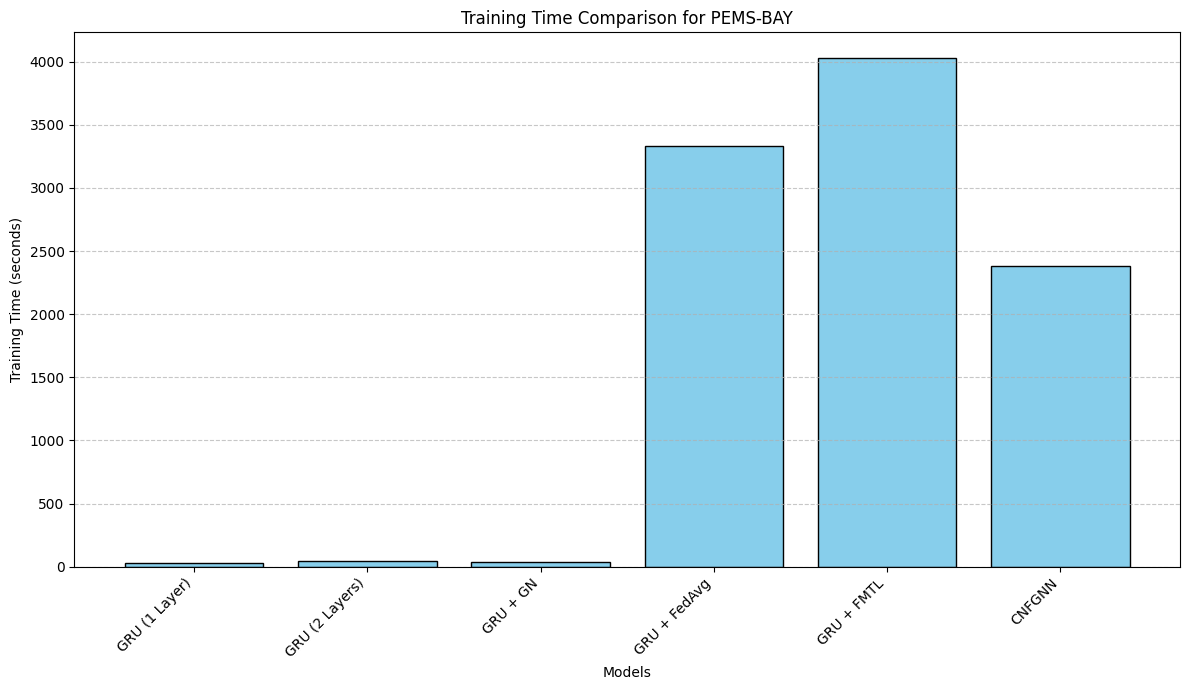

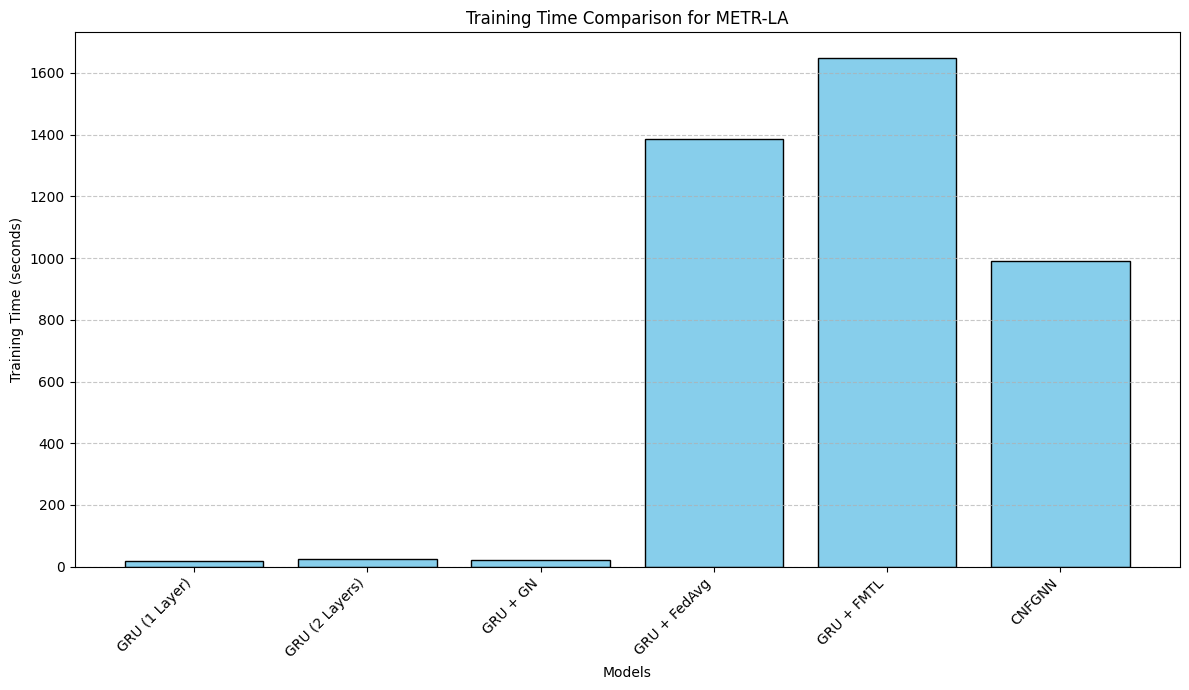

In [ ]:
# Organize results by dataset
organized_results = {}
for model_key, rmse_values in results.items():
    dataset, model_name = model_key.split("_", 1)  # Extract dataset and model name
    if dataset not in organized_results:
        organized_results[dataset] = {}
    organized_results[dataset][model_name] = rmse_values

# Function to Plot RMSE Trends for All Models
def plot_rmse_trends(organized_results):
    """
    Plot RMSE trends for all models and datasets.

    Args:
        organized_results (dict): RMSE results organized by dataset and model.
    """
    for dataset, models in organized_results.items():
        plt.figure(figsize=(12, 7))
        for model, rmse_values in models.items():
            plt.plot(range(1, len(rmse_values) + 1), rmse_values, label=model, marker='o')
        plt.title(f"RMSE Trends for All Models on {dataset}")
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Function to Display RMSE Tables
def display_rmse_tables(organized_results):
    """
    Display RMSE tables for each dataset.

    Args:
        organized_results (dict): RMSE results organized by dataset and model.
    """
    for dataset, models in organized_results.items():
        max_epochs = max(len(rmse) for rmse in models.values())
        table = pd.DataFrame(models, index=[f"Epoch {i}" for i in range(1, max_epochs + 1)])
        print(f"\n{dataset} RMSE Results:")
        print(table)

# Function to Plot Training Times
def plot_training_times(training_times):
    """
    Function to plot training times for all models and datasets.

    Args:
        training_times (dict): Dictionary containing training times for each dataset and model.
    """
    for dataset, times in training_times.items():
        model_names = list(times.keys())
        training_durations = list(times.values())

        plt.figure(figsize=(12, 7))
        plt.bar(model_names, training_durations, color='skyblue', edgecolor='black')
        plt.title(f"Training Time Comparison for {dataset}")
        plt.xlabel("Models")
        plt.ylabel("Training Time (seconds)")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

# Plot RMSE Trends
plot_rmse_trends(organized_results)

# Display RMSE Tables
display_rmse_tables(organized_results)

# Plot Training Times
plot_training_times(training_times)
